# Statistics in Python

In this section, we will cover how you can use Python to do some statistics. There are many packages to do so, but we will focus on four:

- [pandas](https://pandas.pydata.org/)
- [scipy's stats module](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [statsmodels](http://www.statsmodels.org/stable/index.html)
- [seaborn](seaborn.pydata.org).

This notebook is strongly based on the [scipy-lectures.org](http://www.scipy-lectures.org/packages/statistics/index.html) section about statistics.

# Data representation and interaction

## Data as a table

The setting that we consider for statistical analysis is that of multiple *observations* or *samples* described by a set of different *attributes* or *features*. The data can than be seen as a 2D table, or matrix, with columns giving the different attributes of the data, and rows the observations. For instance, the data contained in `data/brain_size.csv`:

In [1]:
!head data/brain_size.csv

"";"Hair";"FSIQ";"VIQ";"PIQ";"Weight";"Height";"MRI_Count"
"1";"light";133;132;124;"118";"64.5";816932
"2";"dark";140;150;124;".";"72.5";1001121
"3";"dark";139;123;150;"143";"73.3";1038437
"4";"dark";133;129;128;"172";"68.8";965353
"5";"light";137;132;134;"147";"65.0";951545
"6";"light";99;90;110;"146";"69.0";928799
"7";"light";138;136;131;"138";"64.5";991305
"8";"light";92;90;98;"175";"66.0";854258
"9";"dark";89;93;84;"134";"66.3";904858


## The pandas data-frame

### Creating dataframes: reading data files or converting arrays
 
#### Reading from a CSV file
Using the above CSV file that gives observations of brain size and weight and IQ (Willerman et al. 1991), the data are a mixture of numerical and categorical values::

In [2]:
import pandas
data = pandas.read_csv('data/brain_size.csv', sep=';', na_values=".")
data

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,Unnamed: 0,Hair,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,1,light,133,132,124,118.0,64.5,816932
1,2,dark,140,150,124,NaN,72.5,1001121
2,3,dark,139,123,150,143.0,73.3,1038437
3,4,dark,133,129,128,172.0,68.8,965353
4,5,light,137,132,134,147.0,65.0,951545
5,6,light,99,90,110,146.0,69.0,928799
6,7,light,138,136,131,138.0,64.5,991305
7,8,light,92,90,98,175.0,66.0,854258
8,9,dark,89,93,84,134.0,66.3,904858
9,10,dark,133,114,147,172.0,68.8,955466


#### Creating from arrays
A `pandas.DataFrame` can also be seen as a dictionary of 1D 'series', eg arrays or lists. If we have 3 ``numpy`` arrays:

In [3]:
import numpy as np
t = np.linspace(-6, 6, 20)
sin_t = np.sin(t)
cos_t = np.cos(t)

We can expose them as a `pandas.DataFrame`:

In [4]:
pandas.DataFrame({'t': t, 'sin': sin_t, 'cos': cos_t}).head()

,t,sin,cos
0,-6.000000,0.279415,0.960170
1,-5.368421,0.792419,0.609977
2,-4.736842,0.999701,0.024451
3,-4.105263,0.821291,-0.570509
4,-3.473684,0.326021,-0.945363


**Other inputs**: [pandas](http://pandas.pydata.org) can input data from SQL, excel files, or other formats. See the [pandas documentation](http://pandas.pydata.org).

### Manipulating data

`data` is a `pandas.DataFrame`, that resembles R's dataframe:

In [5]:
data.shape    # 40 rows and 8 columns

(40, 8)

In [6]:
data.columns  # It has columns

Index(['Unnamed: 0', 'Hair', 'FSIQ', 'VIQ', 'PIQ', 'Weight', 'Height',
       'MRI_Count'],
      dtype='object')

In [7]:
print(data['Hair'].head())  # Columns can be addressed by name

0    light
1     dark
2     dark
3     dark
4    light
Name: Hair, dtype: object


In [8]:
# Simpler selector
data[data['Hair'] == 'light']['VIQ'].mean()

109.45

**Note:** For a quick view on a large dataframe, use its `describe` `pandas.DataFrame.describe`.

In [9]:
data.describe()

,Unnamed: 0,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
count,40.000000,40.000000,40.000000,40.00000,38.000000,39.000000,4.000000e+01
mean,20.500000,113.450000,112.350000,111.02500,151.052632,68.525641,9.087550e+05
std,11.690452,24.082071,23.616107,22.47105,23.478509,3.994649,7.228205e+04
min,1.000000,77.000000,71.000000,72.00000,106.000000,62.000000,7.906190e+05
25%,10.750000,89.750000,90.000000,88.25000,135.250000,66.000000,8.559185e+05
50%,20.500000,116.500000,113.000000,115.00000,146.500000,68.000000,9.053990e+05
75%,30.250000,135.500000,129.750000,128.00000,172.000000,70.500000,9.500780e+05
max,40.000000,144.000000,150.000000,150.00000,192.000000,77.000000,1.079549e+06


In [10]:
# Frequency count for a given column
data['Height'].value_counts()

64.5    4
69.0    3
68.0    3
66.5    3
63.0    2
66.0    2
70.0    2
70.5    2
68.8    2
66.3    2
75.5    2
72.0    1
77.0    1
76.5    1
73.5    1
68.5    1
62.5    1
67.0    1
74.0    1
73.3    1
65.0    1
72.5    1
62.0    1
Name: Height, dtype: int64

In [11]:
# Dummy-code # of hair color (i.e., get N-binary columns)
pandas.get_dummies(data['Hair'])[:15]

,dark,light
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
5,0,1
6,0,1
7,0,1
8,1,0
9,1,0


#### The [split-apply-combine](https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf) pattern
* A very common data processing strategy is to...
    * Split the dataset into groups
    * Apply some operation(s) to each group
    * (Optionally) combine back into one dataset

Pandas provides powerful and fast tools for this. For example the `groupby` function.

**groupby**: splitting a dataframe on values of categorical variables:

In [12]:
groupby_hair = data.groupby('Hair')
for hair, value in groupby_hair['VIQ']:
     print((hair, value.mean()))

('dark', 115.25)
('light', 109.45)


`groupby_hair` is a powerful object that exposes many operations on the resulting group of dataframes:

In [13]:
groupby_hair.mean()

,Unnamed: 0,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
Hair,,,,,,,
dark,21.35,115.0,115.25,111.60,166.444444,71.431579,954855.4
light,19.65,111.9,109.45,110.45,137.200000,65.765000,862654.6


### Exercise 1

* What is the mean value for VIQ for the full population?
* How many dark/light haired people were included in this study?
* What is the average value of MRI counts expressed in log units, for people with dark and light hair?

In [14]:
data['VIQ'].mean()

112.35

In [15]:
groupby_hair['Hair'].count()

Hair
dark     20
light    20
Name: Hair, dtype: int64

In [16]:
np.log(groupby_hair.MRI_Count.mean())

Hair
dark     13.769315
light    13.667770
Name: MRI_Count, dtype: float64

In [17]:
# Create solution here

### Plotting data

Pandas comes with some plotting tools (`pandas.tools.plotting`, using
matplotlib behind the scene) to display statistics of the data in
dataframes.

For example, let's use `boxplot` (in this case even `groupby_hair.boxplot`) to better understand the structure of the data.

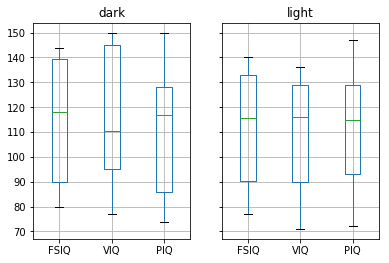

In [18]:
%matplotlib inline
groupby_hair.boxplot(column=['FSIQ', 'VIQ', 'PIQ']);

#### Scatter matrices

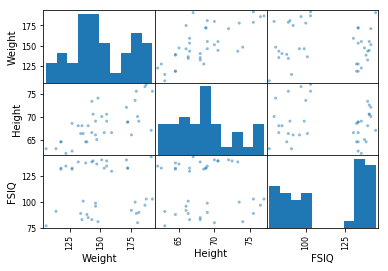

In [19]:
pandas.plotting.scatter_matrix(data[['Weight', 'Height', 'FSIQ']]);

# `scipy.stats` - Hypothesis testing: comparing two groups

For simple [statistical tests](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing), we will use the `scipy.stats` sub-module of [`scipy`](http://docs.scipy.org/doc/).

In [20]:
from scipy import stats

## Student's t-test: the simplest statistical test

### 1-sample t-test: testing the value of a population mean

`scipy.stats.ttest_1samp` tests if the population mean of data is likely to be equal to a given value (technically if observations are drawn from a Gaussian distributions of given population mean). It returns the [T statistic](https://en.wikipedia.org/wiki/Student%27s_t-test), and the [p-value](https://en.wikipedia.org/wiki/P-value) (see the function's help):

In [21]:
stats.ttest_1samp(data['VIQ'], 100)

Ttest_1sampResult(statistic=3.3074146385401786, pvalue=0.002030117404781822)

With a p-value of 10^-28 we can claim that the population mean for the IQ (VIQ measure) is not 0.

### 2-sample t-test: testing for difference across populations

We have seen above that the mean VIQ in the dark hair and light hair populations
were different. To test if this is significant, we do a 2-sample t-test
with `scipy.stats.ttest_ind`:

In [22]:
light_viq = data[data['Hair'] == 'light']['VIQ']
dark_viq = data[data['Hair'] == 'dark']['VIQ']
stats.ttest_ind(light_viq, dark_viq)

Ttest_indResult(statistic=-0.7726161723275011, pvalue=0.44452876778583217)

## Paired tests: repeated measurements on the same indivuals

PIQ, VIQ, and FSIQ give 3 measures of IQ. Let us test if FISQ and PIQ are significantly different. We can use a 2 sample test:

In [23]:
stats.ttest_ind(data['FSIQ'], data['PIQ'])

Ttest_indResult(statistic=0.465637596380964, pvalue=0.6427725009414841)

The problem with this approach is that it forgets that there are links
between observations: FSIQ and PIQ are measured on the same individuals.

Thus the variance due to inter-subject variability is confounding, and
can be removed, using a "paired test", or ["repeated measures test"](https://en.wikipedia.org/wiki/Repeated_measures_design):

In [24]:
stats.ttest_rel(data['FSIQ'], data['PIQ'])

Ttest_relResult(statistic=1.7842019405859857, pvalue=0.08217263818364236)

This is equivalent to a 1-sample test on the difference::

In [25]:
stats.ttest_1samp(data['FSIQ'] - data['PIQ'], 0)

Ttest_1sampResult(statistic=1.7842019405859857, pvalue=0.08217263818364236)

T-tests assume Gaussian errors. We can use a [Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test), that relaxes this assumption:

In [26]:
stats.wilcoxon(data['FSIQ'], data['PIQ'])

WilcoxonResult(statistic=274.5, pvalue=0.10659492713506856)

**Note:** The corresponding test in the non paired case is the [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U), `scipy.stats.mannwhitneyu`.

### Exercise 2

* Test the difference between weights in people with dark and light hair.
* Use non-parametric statistics to test the difference between VIQ in people with dark and light hair.

In [27]:
light_weight = data[data['Hair'] == 'light']['Weight']
dark_weight = data[data['Hair'] == 'dark']['Weight']
stats.ttest_ind(light_weight, dark_weight, nan_policy='omit')

Ttest_indResult(statistic=-4.870950921940696, pvalue=2.2272930183621212e-05)

In [28]:
stats.mannwhitneyu(light_viq, dark_viq)

MannwhitneyuResult(statistic=164.5, pvalue=0.17114434343636575)

**Conclusion**: we find that the data does not support the hypothesis that people with dark and light hair have different VIQ.

In [29]:
# Create solution here

# `statsmodels` - use "formulas" to specify statistical models in Python

Use `statsmodels` to perform linear models, multiple factors or analysis of variance.


## A simple linear regression

Given two set of observations, `x` and `y`, we want to test the hypothesis that `y` is a linear function of `x`.

In other terms:

$y = x * coef + intercept + e$

where $e$ is observation noise. We will use the [statsmodels](http://statsmodels.sourceforge.net) module to:

1. Fit a linear model. We will use the simplest strategy, [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS).
2. Test that $coef$ is non zero.

First, we generate simulated data according to the model:

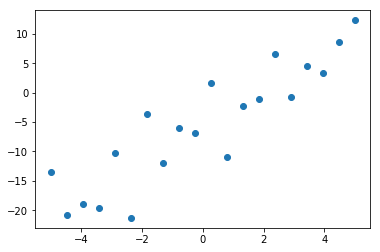

In [30]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 20)
np.random.seed(1)

# normal distributed noise
y = -5 + 3*x + 4 * np.random.normal(size=x.shape)

# Create a data frame containing all the relevant variables
data = pandas.DataFrame({'x': x, 'y': y})

plt.plot(x, y, 'o');

Then we specify an OLS model and fit it:

In [31]:
from statsmodels.formula.api import ols
model = ols("y ~ x", data).fit()

**Note:** For more about "formulas" for statistics in Python, see the [statsmodels documentation](http://statsmodels.sourceforge.net/stable/example_formulas.html).

We can inspect the various statistics derived from the fit::

In [32]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     74.03
Date:                Mon, 10 Sep 2018   Prob (F-statistic):           8.56e-08
Time:                        12:50:56   Log-Likelihood:                -57.988
No. Observations:                  20   AIC:                             120.0
Df Residuals:                      18   BIC:                             122.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5335      1.036     -5.342      0.0

### Terminology

Statsmodels uses a statistical terminology: the `y` variable in statsmodels is called *endogenous* while the `x` variable is called *exogenous*. This is discussed in more detail [here](http://statsmodels.sourceforge.net/devel/endog_exog.html). To simplify, `y` (endogenous) is the value you are trying to predict, while `x` (exogenous) represents the features you are using to make the prediction.

### Exercise 3

Retrieve the estimated parameters from the model above.  
**Hint**: use tab-completion to find the relevant attribute.

In [33]:
model.params

Intercept   -5.533459
x            2.936888
dtype: float64

In [34]:
# Create solution here

## Categorical variables: comparing groups or multiple categories

Let us go back the data on brain size:

In [35]:
data = pandas.read_csv('data/brain_size.csv', sep=';', na_values=".")

We can write a comparison between IQ of people with dark and light hair using a linear model:

In [36]:
model = ols("VIQ ~ Hair + 1", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIQ   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5969
Date:                Mon, 10 Sep 2018   Prob (F-statistic):              0.445
Time:                        12:50:56   Log-Likelihood:                -182.42
No. Observations:                  40   AIC:                             368.8
Df Residuals:                      38   BIC:                             372.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       115.2500      5.308     21.712

### Tips on specifying model
 
***Forcing categorical*** - the 'Hair' is automatically detected as a categorical variable, and thus each of its different values is treated as different entities.

An integer column can be forced to be treated as categorical using:

```python
model = ols('VIQ ~ C(Hair)', data).fit()
```

***Intercept***: We can remove the intercept using `- 1` in the formula, or force the use of an intercept using `+ 1`.

### Link to t-tests between different FSIQ and PIQ

To compare different types of IQ, we need to create a "long-form" table, listing IQs, where the type of IQ is indicated by a categorical variable:

In [37]:
data_fisq = pandas.DataFrame({'iq': data['FSIQ'], 'type': 'fsiq'})
data_piq = pandas.DataFrame({'iq': data['PIQ'], 'type': 'piq'})
data_long = pandas.concat((data_fisq, data_piq))
print(data_long[::8])

     iq  type
0   133  fsiq
8    89  fsiq
16  132  fsiq
24   91  fsiq
32  103  fsiq
0   124   piq
8    84   piq
16  120   piq
24  102   piq
32  110   piq


In [38]:
model = ols("iq ~ type", data_long).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     iq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2168
Date:                Mon, 10 Sep 2018   Prob (F-statistic):              0.643
Time:                        12:50:56   Log-Likelihood:                -364.35
No. Observations:                  80   AIC:                             732.7
Df Residuals:                      78   BIC:                             737.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     113.4500      3.683     30.807      

We can see that we retrieve the same values for t-test and corresponding p-values for the effect of the type of IQ than the previous t-test:

In [39]:
stats.ttest_ind(data['FSIQ'], data['PIQ'])

Ttest_indResult(statistic=0.465637596380964, pvalue=0.6427725009414841)

## Multiple Regression: including multiple factors

Consider a linear model explaining a variable `z` (the dependent
variable) with 2 variables `x` and `y`:

$z = x \, c_1 + y \, c_2 + i + e$

Such a model can be seen in 3D as fitting a plane to a cloud of (`x`,
`y`, `z`) points (see the following figure).

Text(0.5,0,'Z')

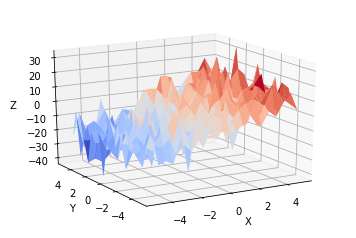

In [40]:
from mpl_toolkits.mplot3d import Axes3D
x = np.linspace(-5, 5, 21)

# We generate a 2D grid
X, Y = np.meshgrid(x, x)

# To get reproducable values, provide a seed value
np.random.seed(1)

# Z is the elevation of this 2D grid
Z = -5 + 3*X - 0.5*Y + 8 * np.random.normal(size=X.shape)

# Plot the data
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1)
ax.view_init(20, -120)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

### Example: the iris data (`data/iris.csv`)

Sepal and petal size tend to be related: bigger flowers are bigger! But is there, in addition, a systematic effect of species?

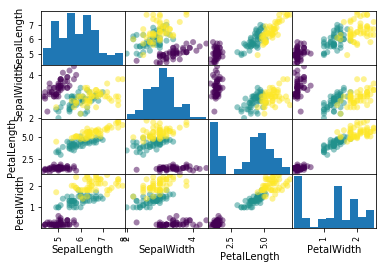

In [41]:
from pandas.plotting import scatter_matrix

#Load the data
data = pandas.read_csv('data/iris.csv')

# Express the names as categories
categories = pandas.Categorical(data['Species'])

# The parameter 'c' is passed to plt.scatter and will control the color
scatter_matrix(data, c=categories.codes, marker='o')

# Plot figure
fig.suptitle("blue: setosa, green: versicolor, red: virginica", size=13)
plt.show()

In [42]:
data = pandas.read_csv('data/iris.csv')
model = ols('SepalWidth ~ Species + PetalLength', data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             SepalWidth   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     44.63
Date:                Mon, 10 Sep 2018   Prob (F-statistic):           1.58e-20
Time:                        12:50:58   Log-Likelihood:                -38.185
No. Observations:                 150   AIC:                             84.37
Df Residuals:                     146   BIC:                             96.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.98

## Post-hoc hypothesis testing: analysis of variance (ANOVA)

In the above iris example, we wish to test if the petal length is different between versicolor and virginica, after removing the effect of sepal width. This can be formulated as testing the difference between the coefficient associated to versicolor and virginica in the linear model estimated above (it is an Analysis of Variance, [ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance). For this, we write a **vector of 'contrast'** on the parameters estimated: we want to test ``"name[T.versicolor] - name[T.virginica]"``, with an [F-test](https://en.wikipedia.org/wiki/F-test):

In [43]:
print(model.f_test([0, 1, -1, 0]))

<F test: F=array([[3.24533535]]), p=0.07369058781700653, df_denom=146, df_num=1>


Is this difference significant?

### Exercise 4

Going back to the brain size + IQ data, test if the VIQ of people with dark and light hair are different after removing the effect of brain size, height, and weight.

In [44]:
data = pandas.read_csv('data/brain_size.csv', sep=';', na_values=".")
model = ols("VIQ ~ Hair + Height + Weight + MRI_Count", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIQ   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     2.733
Date:                Mon, 10 Sep 2018   Prob (F-statistic):             0.0455
Time:                        12:50:58   Log-Likelihood:                -167.03
No. Observations:                  38   AIC:                             344.1
Df Residuals:                      33   BIC:                             352.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       179.9298     97.671      1.842

In [45]:
# Create solution here

# `seaborn` - use visualization for statistical exploration

[Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) combines simple statistical fits with plotting on pandas dataframes.

Let us consider a data giving wages and many other personal information on 500 individuals ([Berndt, ER. The Practice of Econometrics. 1991. NY:Addison-Wesley](http://lib.stat.cmu.edu/datasets/CPS_85_Wages)).

In [46]:
import pandas
data = pandas.read_csv('data/wages.csv', sep=',')
data.head()

,EDUCATION,SOUTH,HAIR,EXPERIENCE,UNION,WAGE,AGE,OCCUPATION,SECTOR,MARR
0,8,0,1,21,0,5.10,35,2,6,1
1,9,0,1,42,0,4.95,57,3,6,1
2,12,0,0,1,0,6.67,19,3,6,1
3,12,0,0,4,0,4.00,22,3,6,0
4,12,0,0,17,0,7.50,35,3,6,0


## Pairplot: scatter matrices

We can easily have an intuition on the interactions between continuous variables using `seaborn.pairplot` to display a scatter matrix:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


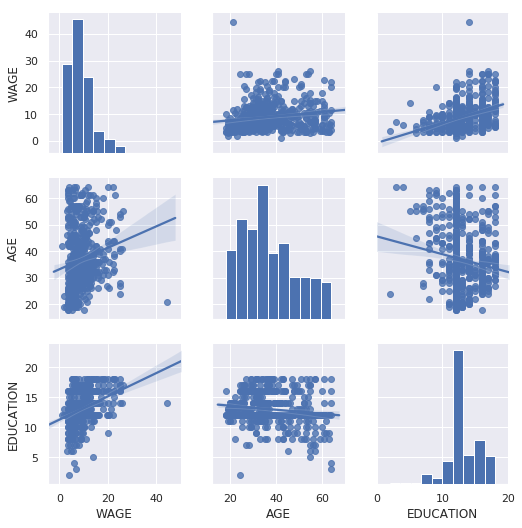

In [47]:
import seaborn
seaborn.set()
seaborn.pairplot(data, vars=['WAGE', 'AGE', 'EDUCATION'], kind='reg')

Categorical variables can be plotted as the hue:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


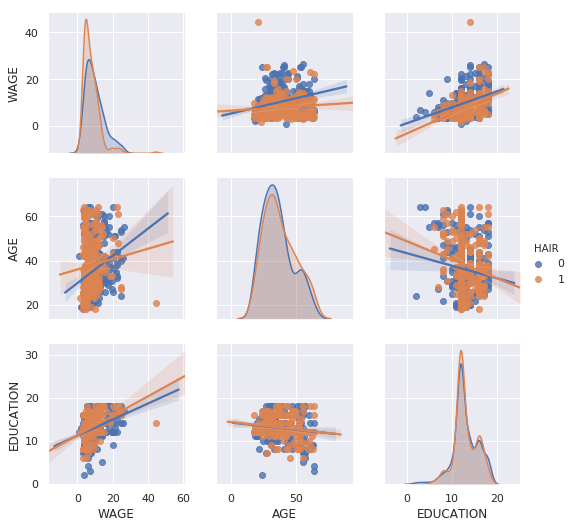

In [48]:
seaborn.pairplot(data, vars=['WAGE', 'AGE', 'EDUCATION'], kind='reg', hue='HAIR')

## lmplot: plotting a univariate regression

A regression capturing the relation between one variable and another, e.g. wage and eduction, can be plotted using `seaborn.lmplot`:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


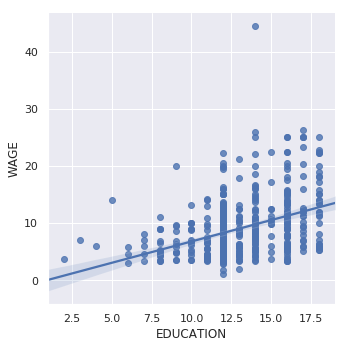

In [49]:
seaborn.lmplot(y='WAGE', x='EDUCATION', data=data)

### Robust regression
Given that, in the above plot, there seems to be a couple of data points that are outside of the main cloud to the right, they might be outliers, not representative of the population, but driving the regression.

To compute a regression that is less sensitive to outliers, one must use a [robust model](https://en.wikipedia.org/wiki/Robust_statistics). This is done in seaborn using ``robust=True`` in the plotting functions, or in statsmodels by replacing the use of the OLS by a "Robust Linear Model", `statsmodels.formula.api.rlm`.

# Testing for interactions

Do wages increase more with education for people with dark hair than with light hair?

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


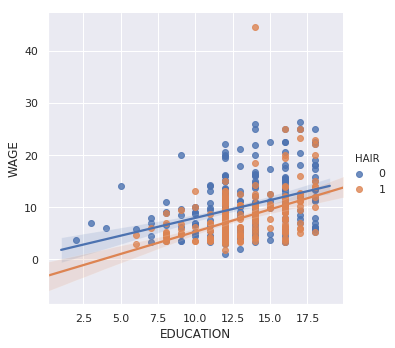

In [50]:
seaborn.lmplot(y='WAGE', x='EDUCATION', hue='HAIR', data=data)

The plot above is made of two different fits. We need to formulate a single model that tests for a variance of slope across the population. This is done via an ["interaction"](http://statsmodels.sourceforge.net/devel/example_formulas.html#multiplicative-interactions).

In [51]:
from statsmodels.formula.api import ols
result = ols(formula='WAGE ~ EDUCATION + HAIR + EDUCATION * HAIR', data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGE   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     41.50
Date:                Mon, 10 Sep 2018   Prob (F-statistic):           4.24e-24
Time:                        12:51:03   Log-Likelihood:                -1575.0
No. Observations:                 534   AIC:                             3158.
Df Residuals:                     530   BIC:                             3175.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1046      1.314      0.

Can we conclude that education benefits people with dark hair more than people with light hair?

# Take home messages

* Hypothesis testing and p-value give you the **significance** of an effect / difference

* **Formulas** (with categorical variables) enable you to express rich links in your data

* **Visualizing** your data and simple model fits matters!

* **Conditioning** (adding factors that can explain all or part of the variation) is an important modeling aspect that changes the interpretation.